In [3]:
import pandas as pd

In [14]:
classified_disputes = pd.read_csv('classified_disputes.csv')
classified_disputes = classified_disputes[['dispute_id','predicted_category','confidence','explanation']]

In [15]:
disputes = pd.read_csv('disputes.csv')
disputes = disputes[['dispute_id', 'amount']]

In [16]:
merged_df = classified_disputes.merge(disputes,how = 'inner', on = 'dispute_id')

In [21]:
merged_df

,dispute_id,predicted_category,confidence,explanation,amount
0,D001,DUPLICATE_CHARGE,0.970,VALIDATED: Multiple SUCCESS transactions found...,999
1,D002,REFUND_PENDING,0.846,"VALIDATED: FAILED transaction, eligible for re...",1250
2,D003,FAILED_TRANSACTION,0.829,VALIDATED: Transaction status is FAILED| Origi...,500
3,D004,FRAUD,0.800,VALIDATED: SUCCESS transaction reported as fra...,1200
4,D005,REFUND_PENDING,0.798,"VALIDATED: FAILED transaction, eligible for re...",750
5,D006,DUPLICATE_CHARGE,0.910,VALIDATED: Multiple SUCCESS transactions found...,1499
6,D007,FAILED_TRANSACTION,0.667,VALIDATED: Transaction status is FAILED| Origi...,299
7,D008,OTHERS,0.507,"Expected to be: FAILED_TRANSACTION, but low co...",5400
8,D009,OTHERS,0.542,"Expected to be: FRAUD, but low confidence score.",1899
9,D010,REFUND_PENDING,0.724,"VALIDATED: FAILED transaction, eligible for re...",650


In [27]:
def suggest_resolution(row):
    ## This completely relies on business logic 
    ## Rule based suggestion depending on confidence as well as amount
    
    category = row['predicted_category']
    confidence = row['confidence']
    amount = row['amount']
    dispute_id = row['dispute_id']
    
    if category == 'DUPLICATE_CHARGE':
        #Taking an auto refund threshold to be 1000 and atleast 85% confidence for duplicate charges which seems reasonable

        if confidence >= 0.85 and amount <= 1000:
            action = 'Auto-refund'
            justification = f"Validated duplicate charge ({amount}). High confidence ({confidence:.2f}) and amount below auto-refund threshold (1000)."
        elif confidence >= 0.7:
            action = 'Manual review'
            justification = f"Duplicate charge detected ({amount}) but requires manual verification due to amount or confidence level."
        else:
            action = 'Ask for more info'
            justification = f"Potential duplicate ({amount}) but low confidence ({confidence:.2f}). Need customer clarification."
    
    elif category == 'FAILED_TRANSACTION':

        if confidence >= 0.8 and amount <= 1000:
            action = 'Auto-refund'
            justification = f"High confidence failed transaction ({amount}). Status confirmed, safe for automatic refund."
        else:
            action = 'Manual review'
            justification = f"Failed transaction ({amount}) needs verification. Confidence: {confidence:.2f}"
    
    elif category == 'FRAUD':
        if amount >= 5000 :
            action = 'Escalate to bank'
            justification = f"High-value fraud case ({amount}). Bank investigation required for amounts >=5000."
        elif confidence >= 0.8:
            action = 'Mark as potential fraud'
            justification = f"Fraud reported for {amount}. High confidence ({confidence:.2f}) warrants fraud flag and investigation."
        else:
            action = 'Manual review'
            justification = f"Potential fraud case ({amount}). Medium confidence requires human assessment."
    
    elif category == 'REFUND_PENDING':

        if confidence >= 0.8 and amount <= 1000:
            action = 'Auto-refund'
            justification = f"Small refund request ({amount}). High confidence and low amount enable automatic processing."
        elif confidence >= 0.7 and amount <= 3000:
            action = 'Manual review'
            justification = f"Refund request ({amount}). Moderate amount requires policy verification before processing."
        elif amount > 3000:
            action = 'Manual review'
            justification = f"High-value refund ({amount}). Manual review required for refund policy compliance."
        else:
            action = 'Ask for more info'
            justification = f"Refund request ({amount}) with low confidence ({confidence:.2f}). Need clarification on refund reason."
    
    else:  # OTHERS
        if amount <= 500:
            action = 'Ask for more info'
            justification = f"Unclear dispute ({amount}). Small amount - gather more details before processing."
        elif amount >= 2500:
            action = 'Manual review'
            justification = f"High-value unclear dispute ({amount}). Human review required due to amount significance."
        else:
            action = 'Ask for more info'
            justification = f"Dispute classification unclear ({amount}). Additional information needed from customer."
    suggested_action = action 
    return dispute_id, suggested_action, justification

def generate_resolutions(classified_df):

    resolutions = []
    
    for idx, row in classified_df.iterrows():
        dispute_id, suggested_action, justification = suggest_resolution(row)
        
        resolutions.append({
            'dispute_id': dispute_id,  
            'suggested_action': suggested_action,
            'justification': justification
        })
    
    return pd.DataFrame(resolutions)

In [28]:
result_df = generate_resolutions(merged_df)

In [29]:
result_df

,dispute_id,suggested_action,justification
0,D001,Auto-refund,Validated duplicate charge (999). High confide...
1,D002,Manual review,Refund request (1250). Moderate amount require...
2,D003,Auto-refund,High confidence failed transaction (500). Stat...
3,D004,Mark as potential fraud,Fraud reported for 1200. High confidence (0.80...
4,D005,Manual review,Refund request (750). Moderate amount requires...
5,D006,Manual review,Duplicate charge detected (1499) but requires ...
6,D007,Manual review,Failed transaction (299) needs verification. C...
7,D008,Manual review,High-value unclear dispute (5400). Human revie...
8,D009,Ask for more info,Dispute classification unclear (1899). Additio...
9,D010,Manual review,Refund request (650). Moderate amount requires...


In [30]:
result_df.to_csv('resolutions.csv')

/var/folders/1q/k68pbfsn5rg9gtdjlvb3pvx80000gn/T/ipykernel_92837/4245129904.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


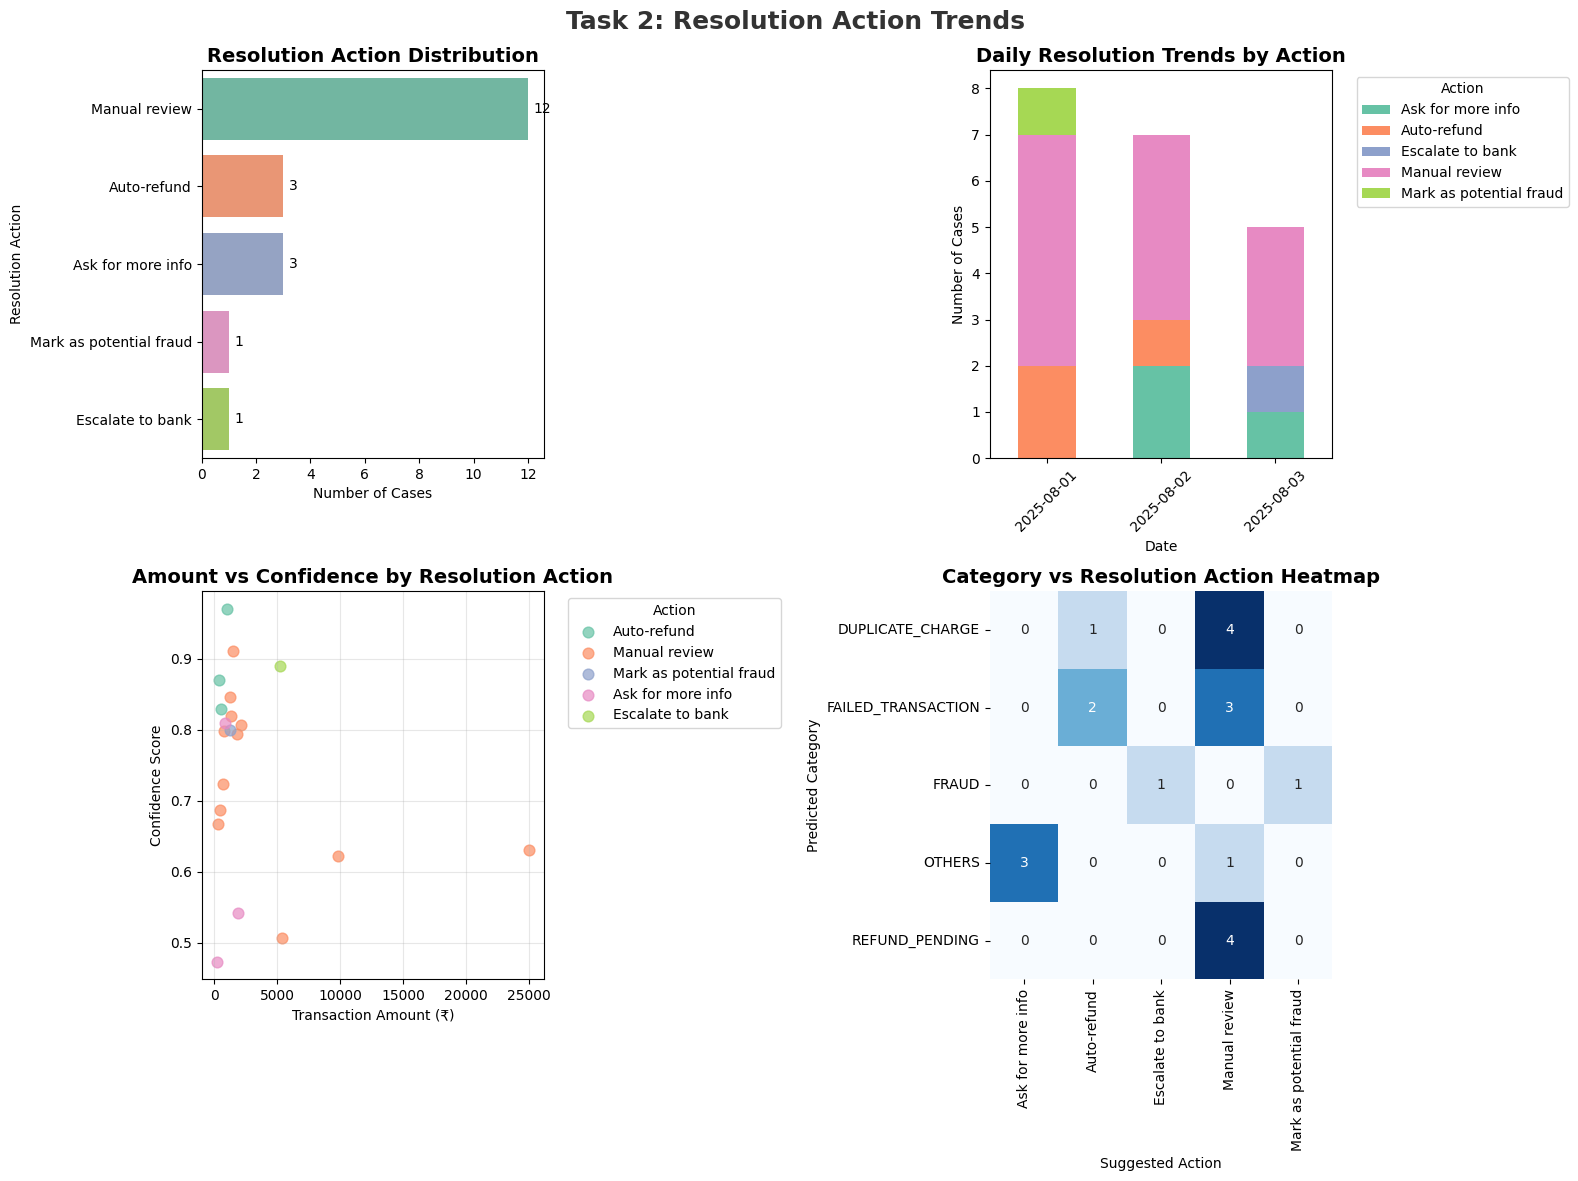

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.style.use("default")
sns.set_palette("Set2")

def visualize_task2_trends(resolutions_df, classified_df, disputes_df):
    """
    Visualize resolution trends from Task 2 with clean merged data and improved aesthetics.
    """

    merged_df = resolutions_df.merge(
        classified_df[['dispute_id', 'predicted_category', 'confidence']],
        on='dispute_id', how='left'
    ).merge(
        disputes_df[['dispute_id', 'amount', 'created_at']],
        on='dispute_id', how='left'
    )

    merged_df['created_at'] = pd.to_datetime(merged_df['created_at'])
    merged_df['date'] = merged_df['created_at'].dt.date

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Task 2: Resolution Action Trends', fontsize=18, fontweight='bold', color="#333333")

    # 1. Resolution Action Distribution (Horizontal Bar)
    action_counts = resolutions_df['suggested_action'].value_counts()
    sns.barplot(
        x=action_counts.values, y=action_counts.index,
        ax=axes[0, 0], palette="Set2"
    )
    axes[0, 0].set_title('Resolution Action Distribution', fontsize=14, fontweight="bold")
    axes[0, 0].set_xlabel('Number of Cases')
    axes[0, 0].set_ylabel('Resolution Action')
    for i, v in enumerate(action_counts.values):
        axes[0, 0].text(v + 0.2, i, str(v), va='center')

    # 2. Daily Resolution Trends (Stacked Bar)
    daily_resolutions = merged_df.groupby(['date', 'suggested_action']).size().unstack(fill_value=0)
    daily_resolutions.plot(
        kind='bar', stacked=True, ax=axes[0, 1],
        color=sns.color_palette("Set2", len(daily_resolutions.columns))
    )
    axes[0, 1].set_title('Daily Resolution Trends by Action', fontsize=14, fontweight="bold")
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Number of Cases')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].legend(title="Action", bbox_to_anchor=(1.05, 1), loc='upper left')

    # 3. Amount vs Confidence by Resolution Action (Scatter)
    actions = merged_df['suggested_action'].unique()
    colors = sns.color_palette("Set2", len(actions))
    for i, action in enumerate(actions):
        action_data = merged_df[merged_df['suggested_action'] == action]
        axes[1, 0].scatter(
            action_data['amount'], action_data['confidence'],
            c=[colors[i]], label=action, alpha=0.7, s=60
        )
    axes[1, 0].set_title('Amount vs Confidence by Resolution Action', fontsize=14, fontweight="bold")
    axes[1, 0].set_xlabel('Transaction Amount (₹)')
    axes[1, 0].set_ylabel('Confidence Score')
    axes[1, 0].legend(title="Action", bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Category vs Action Heatmap
    category_action = pd.crosstab(merged_df['predicted_category'], merged_df['suggested_action'])
    sns.heatmap(
        category_action, annot=True, fmt='d',
        cmap='Blues', ax=axes[1, 1], cbar=False
    )
    axes[1, 1].set_title('Category vs Resolution Action Heatmap', fontsize=14, fontweight="bold")
    axes[1, 1].set_xlabel('Suggested Action')
    axes[1, 1].set_ylabel('Predicted Category')

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.savefig('task2_resolution_trends.png', dpi=300, bbox_inches='tight')
    plt.show()


disputes_df = pd.read_csv('disputes.csv')
visualize_task2_trends(result_df, classified_disputes, disputes_df)
